In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

# Closed Loop using a PCA mapping from myosin to flow

## Load geometric information

In [2]:
from scipy.io import loadmat

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


## Build a PCA translation model

In [4]:
from utils.decomposition_utils import *
from utils.translation_utils import *
from utils.dataset import *

transform=Reshape2DField()
pmg_cf_mask = np.load('Public/Masks/pmg_cf_mask.npy')

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform)
vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform)

100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


Found SVDPipeline for this dataset!
Found SVDPipeline for this dataset!
0.6902713108980763
(30, 2, 236, 200) (30, 2, 236, 200) (30, 2, 2, 236, 200) (30, 2, 236, 200)


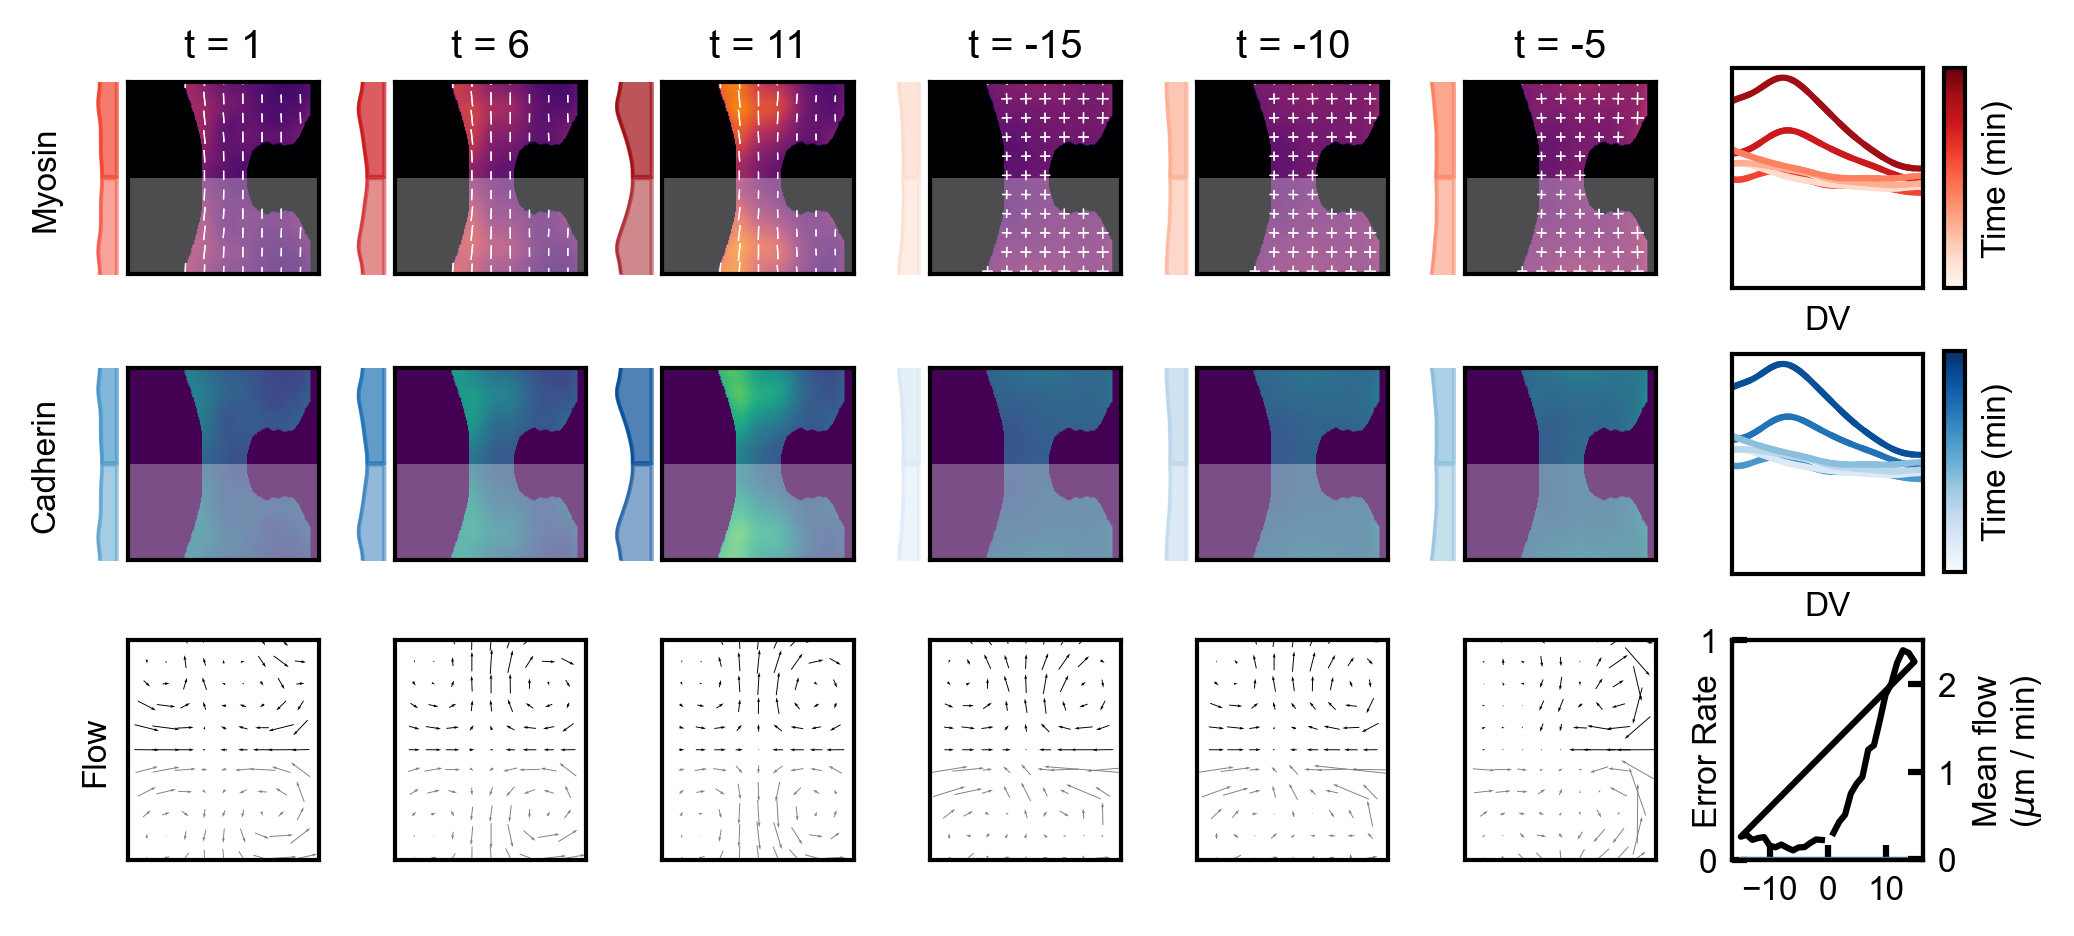

In [20]:
sqh_model, sqh_df = get_decomposition_results(sqh_dataset, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
vel_model, vel_df = get_decomposition_results(vel_dataset, model_name='SVDPipeline')

def process(df, tmin=-15, tmax=15):
    df = df[(df.time >= tmin) & (df.time <= tmax)].reset_index(drop=True)
    df = df.drop(['index', 'set', 'Unnamed: 0', 'eIdx', 't', 'res', 'mag'], axis=1)
    df = df.sort_values(['embryoID', 'time'])
    return df

sqh_df = process(sqh_df)
vel_df = process(vel_df)

keep = np.zeros(16, dtype=bool)
keep[:] = True
X = sqh_df.filter(like='param').values[:, keep]
y0 = vel_df.filter(like='param').values[:, keep]

from sklearn.linear_model import Ridge
model = Ridge(alpha=10.)

model.fit(X, y0)
print(model.score(X, y0))

t = sqh_df.time[:30].values
X = X[:30]
y0 = y0[:30]

y = model.predict(X)

v0 = vel_model.inverse_transform(y0, keep)
v = vel_model.inverse_transform(y, keep)

m0 = sqh_model.inverse_transform(X, keep)
m0 = m0.reshape([30, 2, 2, 236, 200])
s0 = np.linalg.norm(m0, axis=(1))

print(v0.shape, v.shape, m0.shape, s0.shape)

comparison_plot(m0, m0,
                s0, s0,
                v, v0,
                t, dt=5, mask=np.s_[...])

## Plotting script

In [3]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'


N0, N1 = 90, 110

def plot_with_cuts(ax, z, **kwargs):
    plot_tensor2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    cut_Y = np.sum(znorm[:118, N0:N1], axis=1) / np.sum(base[:118, N0:N1], axis=1)
    return cut_Y
    
def plot(m, v, t, dt=5, mmin=None, mmax=None, mask=None):
    dynamic_mask = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
    dynamic_time = np.load('Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
    msk = interp1d(dynamic_time, dynamic_mask, axis=0, fill_value='extrapolate')

    N = int(np.ceil(len(t) / dt))

    fig, ax = plt.subplots(2, N, figsize=(N+1, 1), dpi=300)
    fig.subplots_adjust(hspace=0, wspace=0.1)
    ax_cut = fig.add_axes([.92, 0.125, .75/N, 0.75])

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
        
    cut_sqh = []
    offset = 20
    for i in range(N):
        ax[0, i].set_title('t = %d' % (t[dt*i]))
        vi = v[dt*i].copy()
        vi[0] *= -1
        plot_vector2D(ax[0, i], vi, skip=20)
        ax[0, i].invert_yaxis()
        
        alpha = msk(t[dt*i]).astype(float)[mask]
        alpha[alpha == 0] = 1

        s1 = plot_with_cuts(ax[1, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0, alpha=alpha)    
        cut_sqh.append(s1)
        
        y = np.linspace(*ax[1, i].get_ylim(), len(s1))
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + offset)/ (np.max(t) + offset))
        ax_cut.plot(y, s1, color=sqh_color)
    
    for i in range(N):
        cut = cut_sqh[i]
        color = 'firebrick'
        y = np.linspace(*ax[1, i].get_ylim(), len(cut))

        ax_Y = ax[1, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[1, i])
        ax_Y.plot(cut, y, color=color, lw=0.5)
        ax_Y.fill_betweenx(y, np.ones_like(cut)*ax_cut.get_ylim()[0], cut,
                           color=color, alpha=0.7)

        ax_Y.set(xticks=[], yticks=[])
        ax_Y.set_xlim(ax_cut.get_ylim())
        ax_Y.invert_xaxis()
        ax_Y.axis('off')
            
    ax_cut.set(xticks=[], yticks=[], xlabel='DV')    

    lp=16
    ax[1, 0].set_ylabel('Myosin', labelpad=lp)
    ax[0, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 ax=ax_cut, label='Time (min)', ticks=[])

from utils.plot_utils import *

def comparison_plot(m, m0,
                    c, c0,
                    v, v0,
                    t, dt=5,
                    mask=np.s_[..., 20:-20, 0:-25]):
    N = int(np.ceil(len(t) / dt))
    fig, ax = plt.subplots(3, N+1, figsize=(N+1, 3.5), dpi=300, constrained_layout=True)

    mnorm = np.linalg.norm(m0[mask], axis=(1, 2))[..., :-20]
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    cmin = np.min(c0[mask])
    cmax = np.max(c0[mask])
        
    cut_cad = []
    cut_sqh = []
    
    alpha = np.zeros(m.shape[-2:])
    alpha0 = np.zeros_like(alpha)
    
    al = 0.7
    alpha[118:] = 1
    alpha0[:118] = al
    
    mwargs = dict(cmap='inferno', vmin=mmin, vmax=mmax)
    cwargs = dict(cmap='viridis', vmin=cmin, vmax=cmax)
    
    vfc = 40
    apc = 10
    skip = 20
    ylim = [dv_min+vfc, dv_max-vfc]
    xlim = [ap_min, ap_max]
    
    slc = np.s_[..., ::skip, ::skip]
    X = np.linspace(ap_min, ap_max, m.shape[-1])
    Y = np.linspace(dv_min, dv_max, m.shape[-2])
    Y, X = np.meshgrid(Y, X, indexing='ij')
    
    top = np.s_[..., 118:, :]
    bot = np.s_[..., :118, :]
    vwargs = dict(pivot='middle', width=0.005)

    axms = []
    axcs = []
    
    for i in range(N):
        ii = dt * i
        ax[0, i].set_title('t = %d' % (t[ii]))
    
        mwargs['both'] = t[ii] < 0
        color=plt.get_cmap('Reds')((t[ii] + 20)/ (np.max(t) + 20))
        plot_tensor2D(ax[0, i], m[ii], alpha=alpha, **mwargs)
        plot_tensor2D(ax[0, i], m0[ii], alpha=alpha0, **mwargs)
        
        def get_cut(z):
            znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
            base = np.ones_like(znorm)
            base[np.isnan(znorm)] = 0
            znorm = np.nan_to_num(znorm)
            cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
            return cut
        
        
        y = np.linspace(dv_min, dv_midpoint, 118)
        cut = get_cut(m[ii])
        cut0 = get_cut(m0[ii])
        ax[0, -1].plot(y, cut[:118], color=color)
        ax[0, -1].plot(y, cut0[:118], color=color, linestyle='--')
        
        cut = cut[118:]
        cut0 = cut0[:118]
        ax_Y = ax[0, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[0, i])
        ax_Y.plot(cut, y+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(y+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, y, color=color, lw=0.5, alpha=al)
        ax_Y.fill_betweenx(y, 0, cut0, color=color, alpha=0.7*al)
        axms.append(ax_Y)
        
        color=plt.get_cmap('Blues')((t[ii] + 20)/ (np.max(t) + 20))
        color_2D(ax[1, i], c[ii], alpha=alpha, **cwargs)
        color_2D(ax[1, i], c0[ii], alpha=alpha0, **cwargs)
    
        y = np.linspace(dv_min, dv_midpoint, 118)
        cut = get_cut(c[ii])
        cut0 = get_cut(c0[ii])
        ax[1, -1].plot(y, cut[:118], color=color)
        ax[1, -1].plot(y, cut0[:118], color=color, linestyle='--')
        
        cut = cut[118:]
        cut0 = cut0[:118]
        ax_Y = ax[1, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[1, i])
        ax_Y.plot(cut, y+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(y+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, y, color=color, lw=0.5, alpha=al)
        ax_Y.fill_betweenx(y, 0, cut0, color=color, alpha=0.7*al)
        axcs.append(ax_Y)
        
        ax[2, i].quiver(X[bot][slc], Y[bot][slc], 
                        v0[ii, 1][bot][slc], v0[ii, 0][bot][slc],
                        color='grey', **vwargs)
        ax[2, i].quiver(X[top][slc], Y[top][slc], 
                        v[ii, 1][top][slc], v[ii, 0][top][slc],
                        color='black', **vwargs)
        ax[2, i].set(xticks=[], yticks=[])

        
        for j in range(3):
            ax[j, i].set(xlim=xlim, ylim=ylim)
            
    ax[0, -1].set_xlim([dv_min+vfc, dv_midpoint])
    ax[1, -1].set_xlim([dv_min+vfc, dv_midpoint])

    
    for i in range(N):
        axms[i].set(xlim=ax[0, -1].get_ylim())
        axms[i].invert_xaxis()
        axms[i].axis('off')
            
        axcs[i].set(xlim=ax[1, -1].get_ylim())
        axcs[i].invert_xaxis()
        axcs[i].axis('off')
            
    ax[0, -1].set(xticks=[], yticks=[], xlabel='DV')    
    ax[1, -1].set(xticks=[], yticks=[], xlabel='DV')
    ax[0, -1].autoscale(axis='y')
    ax[1, -1].autoscale(axis='y')

    
    lp=16
    ax[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig.subplots_adjust(right=0.98, wspace=0.4, hspace=0.3)


    cax = fig.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])
    
    res_m = mean_norm_residual(m0[mask], m[mask]).mean(axis=(1, 2))
    res_c = residual(c0[mask], c[mask]).mean(axis=(1, 2))
    res_v = residual(v0[mask], v[mask]).mean(axis=(1, 2))
    vnorm = np.linalg.norm(v, axis=1).mean(axis=(1, 2))
    ax[2, N].plot(t, res_m, color='firebrick')
    ax[2, N].plot(t, res_c, color='steelblue')
    
    
    
    ax2 = ax[2, N].twinx()
    ax2.plot(t, vnorm, color='black')
    
    ax[2, N].set_ylabel('Error Rate', labelpad=-6)
    ax2.set_ylabel('Mean flow\n($\mu$m / min)')
    ax[2, N].set_yticks([0, 1])
    ax[2, N].set_ylim([0, 1])
    
#plot(m, v, t, dt=10, mmin=mmin, mmax=mmax, mask=mask)

## Integrate!

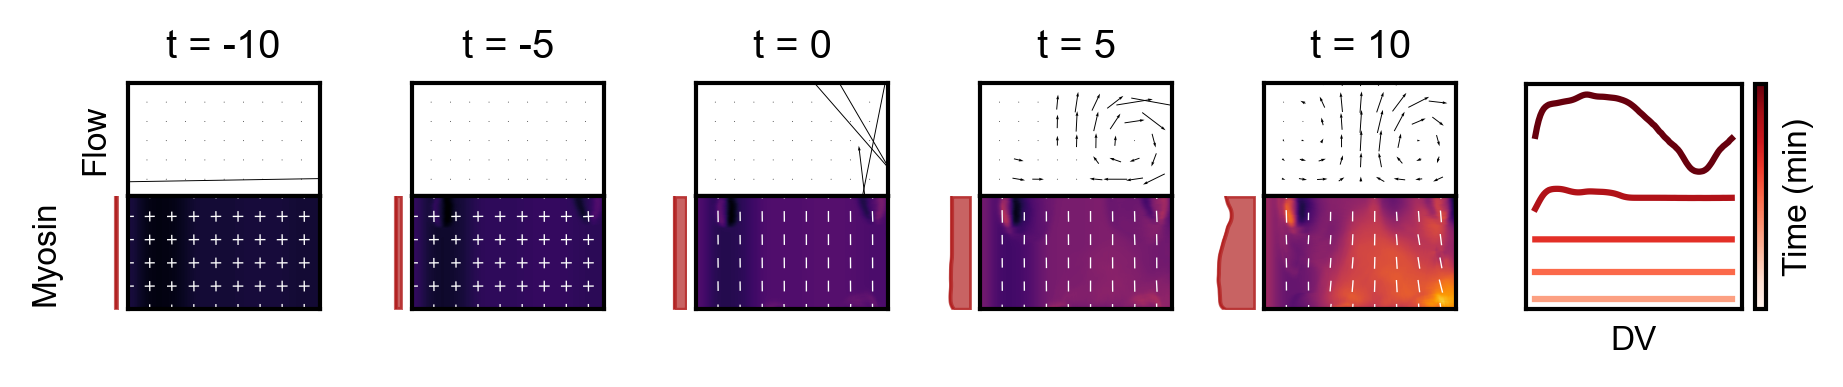

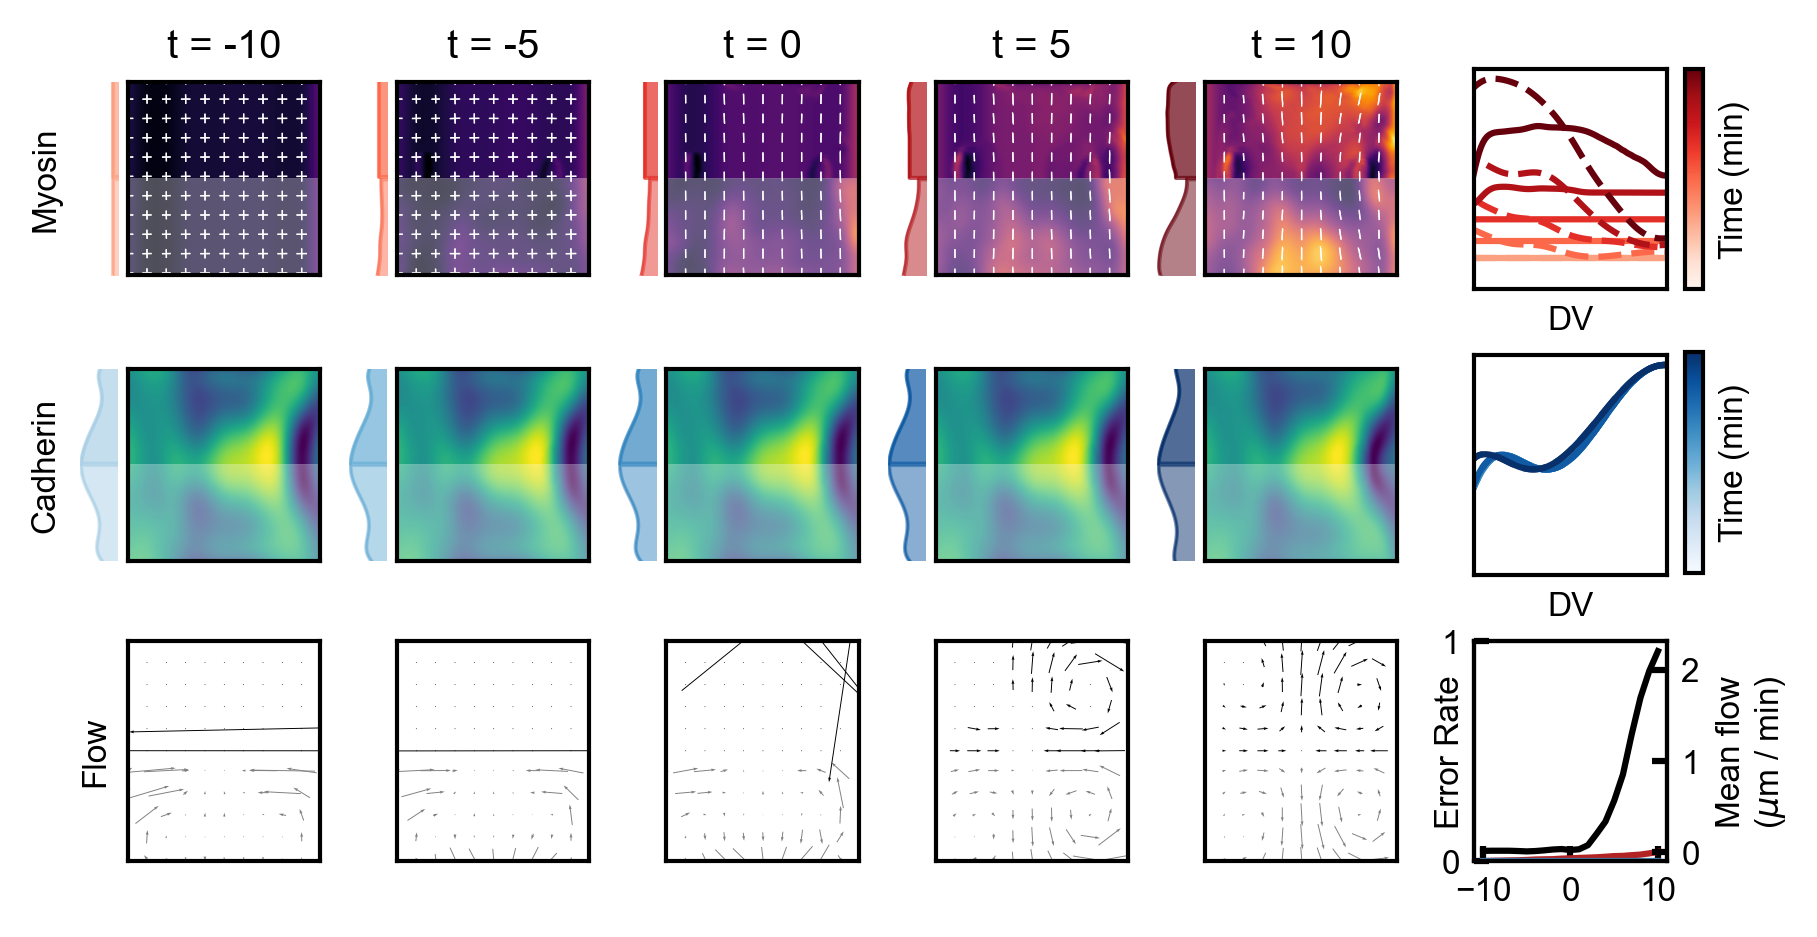

In [38]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition_utils import LeftRightSymmetrize
from utils.plot_utils import *

class ClosedFlyLoop(object):
    def __init__(self, YY, XX, v_model,
                 thresh=0.,
                 v_int=None,
                 sigma=3):
        super(ClosedFlyLoop, self).__init__()
        self.v_model = v_model
        self.v_int = v_int
        
        self.thresh = thresh
        self.gamma_dv = np.array([
                [1., 0.], 
                [0., 0.]
        ])[..., None, None]
        
        self.nDV = YY.shape[0]
        self.nAP = XX.shape[0]

        self.dAP = XX[1] - XX[0]
        self.dDV = YY[1] - YY[0]
        self.sigma = sigma
        
        self.Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        
    def embryo_pad(self, x0, pad_width=20):
        '''
        x0 is a [..., H, W] field 
        We will pad it periodic in the DV direction (H) 
            and constant in the AP direction (W)
        '''
        x = x0.reshape([-1, *x0.shape[-2:]])
        x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode='wrap')
        x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode='edge')
        x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
        return x
    
    def gradient(self, x0):
        pad_width=int(4*self.sigma)
        x = self.embryo_pad(x0, pad_width=pad_width)

        dY_x = gaussian_filter1d(x, axis=-2, sigma=self.sigma, order=1, mode='nearest') / self.dDV
        dX_x = gaussian_filter1d(x, axis=-1, sigma=self.sigma, order=1, mode='nearest') / self.dAP
        return np.stack([
            dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
            dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
        ], axis=-1)
    
    def covariant_gradient(self, x0):
        grad_x = self.gradient(x0)
        if len(x0.shape) == 3: #Vector
            grad_x += np.einsum('yxijk,kyx->iyxj', self.Gijk, x0)
        elif len(x0.shape) == 4: #Tensor
            grad_x += np.einsum('yxikl,ljyx->ijyxk', self.Gijk, x0) + \
                      np.einsum('yxjkl,ilyx->ijyxk', self.Gijk, x0)
        return grad_x
    
    def get_velocity(self, t, y):
        if self.v_int is None: 
            v, _ = VAE.forward(self.v_model, y.reshape([-1, *y.shape[-3:]]))
        else:
            v = self.v_int(t)
        
        #Left-right symmetrize
        v_lr = np.flip(v, (-2,)).copy()
        v_lr[..., 0, :, :] *= -1
        v = 0.5 * (v + v_lr)
        
        #Threshold
        vnorm = np.linalg.norm(v, axis=-3, keepdims=True)
        mask = vnorm >= self.thresh
        v *= mask
                
        return v
        
    def forward(self, t, y):
        #Get myosin and source
        y = y.reshape([5, self.nDV, self.nAP])
        m = y[:4].reshape([2, 2, self.nDV, self.nAP])
        s = y[4:].squeeze()
        
        #Compute flow from myosin/cadherin
        v = self.get_velocity(t, y[:4]).squeeze()

        #Gradients
        d1_m = self.covariant_gradient(m)
        d1_s = self.covariant_gradient(s)
        d1_v = self.covariant_gradient(v)

        #Flow derivative tensors
        O = -0.5 * (np.einsum('iyxj->ijyx', d1_v) - \
                    np.einsum('jyxi->ijyx', d1_v))
        E = 0.5 * (np.einsum('iyxj->ijyx', d1_v) + \
                   np.einsum('jyxi->ijyx', d1_v))

        #Active/Passive strain decomposition
        deviatoric = m - 0.5 * np.einsum('kkyx,ij->ijyx', m, np.eye(2))

        m_0 = np.linalg.norm(m, axis=(0, 1), keepdims=True).mean(axis=(2, 3), keepdims=True)
        dev_mag = np.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

        devE = np.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

        E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
        E_active = 0.5 * E_active * dev_mag / m_0 
        E_passive = E - E_active

        mE = np.einsum('ikyx,kjyx->ijyx', m, E_passive) + \
             np.einsum('ikyx,kjyx->ijyx', E_passive, m) 

        mE = m * np.einsum('kkyx->yx', E_passive)
        trm = np.einsum('kkyx->yx', m)[None, None]

        
        #Source is passively advected
        sdot = -1.000 * np.einsum('iyx,yxi->yx', v, d1_s)
        
        s = s[None, None]
        #Myosin dynamics
        mdot =  -1.000 * np.einsum('kyx,ijyxk->ijyx', v, d1_m)
        mdot -= +1.000 * np.einsum('ikyx,kjyx->ijyx', O, m)
        mdot -= -1.000 * np.einsum('ikyx,kjyx->ijyx', m, O)  
        
        mdot += -0.010 * m
        mdot += 1.351 * mE
        mdot += 0.012 * trm * self.gamma_dv
        mdot += 0.221 * trm * m
        
        #mdot += -1 * (0.016 - 0.026 * s) * m
        #mdot += (1.319 - 0.290 * s) * mE
        #mdot += (0.026 - 0.003 * s) * trm * self.gamma_dv
        #mdot += (0.129 + 0.007 * s) * trm * m

        #mdot += -1 * (0.008 - 0.075 * s) * m
        #mdot += (1.378 - 1.212 * s) * mE
        #mdot += (0.013 - 0.004 * s) * trm * self.gamma_dv
        #mdot += (0.194 - 0.525 * s) * trm * m

        
        ydot = np.concatenate([
            mdot.reshape([4, self.nDV, self.nAP]),
            sdot.reshape([1, self.nDV, self.nAP]),
        ])

        return ydot.flatten()
    
def integrate(m0, s0, v_model, t, YY, XX, v0=None, thresh=0.):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field determined by ML
    and two source fields
    ''' 
        
    #Set up interpolators for control fields
    if v0 is None:
        v_int = None
    else:
        v_int = interp1d(t, v0, axis=0, fill_value='extrapolate')
    
    model = ClosedFlyLoop(YY, XX, v_model, 
                          v_int=v_int,
                          thresh=thresh,
                          sigma=3)

    y0 = np.concatenate([
        m0.reshape([4, *m0.shape[-2:]]),
        s0.reshape([1, *s0.shape[-2:]]),
    ])
    y0 = y0.flatten()
    
    out = solve_ivp(model.forward, [t[0], t[-1]], y0, method='RK45', t_eval=t)
    y = out['y'].T.reshape([-1, 5, model.nDV, model.nAP])
    m = y[:, :4].reshape([-1, 2, 2, *y.shape[-2:]])
    s = y[:, 4:]
    v = model.get_velocity(t, y[:, :4])
            
    return model, (m, s, v, t)

'''
Collect initial conditions - m, c, v, gamma_d, gamma_dv, and time
'''
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    tmin = -10
    sigma = 5
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['X_raw/Dorsal_Source'][t_mask, ...][()]
    
    s0 = np.load('ClosedLoopPINN/DorsalSource_IC.npy')[None]
    
    s0 = gaussian_filter(s0, sigma=(0, sigma, sigma))
    v0 = data['fields/v'][t_mask, ...][()]
    v0 = LeftRightSymmetrize().fit_transform(v0)
    t0 = t[t_mask, ...][()]
    
    #If we're using synthetic ICs, remove DV grading
    m0_mean = np.mean(m0[0], axis=-2, keepdims=True)
    m0[0] = np.broadcast_to(m0_mean, m0[0].shape)

model, (m, s, v, t) = integrate(
    m0[0], s0[0], None,
    t0, dv, ap, v0=v0, thresh=0.5)
s0 = s

mnorm = np.linalg.norm(m0, axis=(1, 2))
mmin = np.min(mnorm)
mmax = np.max(mnorm)
mask = np.s_[..., 20:-20, 0:-25]

plot(m, v, t, dt=5, mmin=mmin, mmax=mmax, mask=mask)
comparison_plot(m, m0,
                s, s0,
                v, v0,
                t, dt=5)